In [4]:
import numpy as np
import matplotlib.pyplot as plt
import copy

In [11]:
def rk4(x_init, t_init, dt, f):
    # f = f(t, x) - the function representing the time derivative of the state vector, x
    # returns the next state
    k1 = f(t_init, x_init)
    k2 = f(t_init + dt/2, x_init + dt * k1/2)
    k3 = f(t_init + dt/2, x_init + dt * k2/2)
    k4 = f(t_init + dt, x_init + dt * k3)

    return x_init + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)


In [12]:
def spring_dynamics(t, x, m=1.0, k=5.0, c=1.0):
    # x = [position, velocity]
    return np.array([x[1], -(k / m) * x[0] - (c / m) * x[1]])

In [56]:
def periodic_driver(t, x, f=1.5, w=0.5/np.pi):
    return np.array([0, f * np.cos(w * t)])

In [113]:
def driven_spring_example():
    x_init = [2.0, -1.0]
    xs = []
    xs.append(copy.copy(x_init))
    dt = 0.01
    undamped_spring_dynamics = lambda t, y: spring_dynamics(t, y, 1.0, 5.0, 0.0) + periodic_driver(t, y)
    
    for i in range(2000):
        xs.append(rk4(xs[-1], dt * i, dt, undamped_spring_dynamics))

    return xs

In [114]:
def damped_spring_example():
    y_init = [1.0, -1.0]
    ys = []
    ys.append(copy.copy(y_init))
    dt = 0.01
    damped_spring_dynamics = lambda t, y: spring_dynamics(t, y, 1.0, 5.0, 2.0)
    
    for i in range(20000):
        ys.append(rk4(ys[-1], dt * i, dt, damped_spring_dynamics))

    return ys

In [89]:
def cartpole_dynamics(t, z, u, u_max=1.0, m_cart=1.0, m_pend=1.0, l_pend=1.0):
    # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    # u = force exerted on cart, clamped between +/-u_max
    u = np.clip(u, -u_max, u_max)
    cosz1 = np.cos(z[1])
    sinz1 = np.sin(z[1])
    alpha = (m_pend + m_cart) / (m_pend * l_pend)
    g = 9.8
    denom = (cosz1 * cosz1 - alpha)

    return np.array(
        [
            z[2],
            z[3],
            (-g * sinz1 * cosz1 - u - (z[3]**2) * sinz1) / denom,
            (alpha * g * sinz1 + u * cosz1 + (z[3]**2 * sinz1 * cosz1)) / denom
         ]
    )

In [116]:
def cartpole_demo():
    z_init = [1.0, 2.0 * np.pi / 3.0, 1.0, 0.0]
    zs = []
    zs.append(copy.copy(z_init))
    dt = 0.01
    unforced_dynamics = lambda t, y : cartpole_dynamics(t, y, 0.0)
    
    for i in range(2000):
        zs.append(rk4(zs[-1], dt * i, dt, unforced_dynamics))

    def pendulum_position(z, l_pend):
        # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
        return np.array([z[0] + l_pend * np.sin(z[1]), -l_pend * np.cos(z[1])])
    
    pendulum_positions = [pendulum_position(z, 1.0) for z in zs]

    fig = plt.figure()
    ax = fig.add_subplot()
    plt.plot([p[0] for p in pendulum_positions], [p[1] for p in pendulum_positions])
    # ax.set_aspect('equal', adjustable='box')
    ax.axis('equal')
    plt.show()

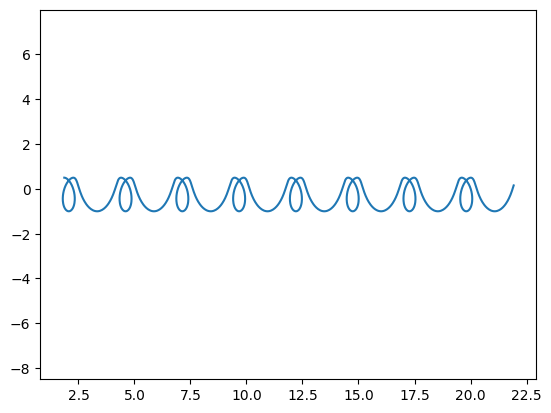

In [117]:
cartpole_demo()

The nonlinear system dynamics is governed by

\begin{equation}
    \frac{dz}{dt} = f(z, u)
\end{equation}

\begin{equation}
    f(z, u) : \mathbb{R}^n \times \mathbb{R}^m \rightarrow \mathbb{R}^n
\end{equation}

Linearizing $f(z, u)$ around a set point $(z_k, u_k)$ gives

\begin{equation}
    f(z, u) \approx f(z_k, u_k) + \frac{\partial f(z_k, u_k)}{\partial z} (z - z_k) + \frac{\partial f(z_k, u_k)}{\partial u}(u - u_k) = f(z_k, u_k) + A(z - z_k) + B(u - u_k)
\end{equation}

\begin{equation}
    f(z, u) \approx f(z_k, u_k) - A z_k - B u_k + A z + B u
\end{equation}

In [125]:
def linearized_cartpole_dynamics(t, z, u, u_max=1.0, m_cart=1.0, m_pend=1.0, l_pend=1.0):
    # z = [cart_pos, pend_angle, cart_pos_speed, pend_angle_speed]
    # u = force exerted on cart, clamped between +/-u_max
    # linearizes the cartpole dynamics about `z` and `u`, returns the `A` and `b` matrices
    #    `z_dot = f(t, z, u) ~ f(t_0, z_0, u_0) + grad(f, z)(t_0, z_0, u_0) ^ T (z - z_0) + grad(f, u)(t_0, z_0, u_0) ^ T (u - u_0)
    #    `A` - Jacobian of cartpole dynamics with respect to state, `z`
    #    `r` - affine part of the linear approximation of cartpole dynamics
    #    `b` - Jacobian of cartpole dynamics with respect to control input, `u`
    # Returns `A`, `b`, `r`
    A = np.zeros((4, 4))
    b = np.zeros(4)

    cosz1 = np.cos(z[1])
    sinz1 = np.sin(z[1])
    alpha = (m_pend + m_cart) / (m_pend * l_pend)
    g = 9.8
    denom = (cosz1 * cosz1 - alpha)

    A[0, 2] = 1.0
    A[1, 3] = 1.0
    A[2, 1] = ((g * sinz1 * sinz1 - g * cosz1 * cosz1 - (z[3] ** 2) * cosz2) / denom) + 2.0 * ((sinz1 * cosz1 * (-g * sinz1 * cosz1 - u * cosz1 + (z[3] ** 2) * sinz1 * cosz1)) / (denom * denom))
    A[2, 3] = -2.0 * z[3] * sinz1 / denom
    A[3, 1] = ((alpha * g * cosz1 - u * sinz1 - (z[3] ** 2) * (sinz1 * sinz1 - cosz1 * cosz1)) / denom) + 2.0 * ((sinz1 * cosz1) * (alpha * g * sinz1 + u * cosz1 + (z[3] ** 2) * sinz1 * cosz1) / (denom * denom))
    A[3, 3] = 2.0 * z[3] * sinz1 * cosz1 / denom

    b[2] = -1.0 / denom
    b[3] = -cosz1 / denom

    r = cartpole_dynamics(t, z, u, u_max, m_cart, m_pend, l_pend) - np.dot(A, z) - b * u

    return A, b, r

## How I want to do this
$N + 1$ timesteps going from $[0, N]$

$T$ time length

$dt = T / N$ timestep

\begin{equation}
    z \in \mathbb{R}^4 \\
    z = \begin{bmatrix}
        x_c, \\
        \phi, \\
        \dot{x_c}, \\
        \dot{\phi}
    \end{bmatrix}
\end{equation}

where $x_c$ is the horizontal cart position, and $\phi$ is the angle of the pendulum relative to the $-\hat{y}$ axis

$u \in \mathbb{R}$

One control input, $u_i$, for each timestep $~\forall i \in [0, N-1]$

One state variable, $z_i$, for each timestep $~\forall i \in [0, N]$

Decision variable, $x \in \mathbb{R}^{N + 1 + 4 (N + 1)} = \mathbb{R}^{5 (N + 1)}$

Decision variable is patterned as 

\begin{equation}
    x = \begin{bmatrix}
        u_0, \\
        u_1, \\
        \vdots \\
        u_{N-1}, \\
        u_{N}, \\
        z_0, \\
        z_1, \\
        \vdots \\
        z_{N-1}, \\
        z_{N}
    \end{bmatrix}
\end{equation}

<!-- \begin{equation}
    x = \begin{bmatrix}
        z_0, \\
        u_0, \\
        z_1, \\
        u_1, \\
        \vdots \\
        z_{N-1}, \\
        u_{N-1}, \\
        z_{N}
    \end{bmatrix}
\end{equation} -->

In [118]:
def build_A_and_C(F, b, f, z_init, z_final, N, dt):
    # Builds the parameters of the linear equation Ax = c from the
    # parameters of an LTI dynamical system. `A` and `c` represent
    # collocation constraints on the dynamics of a system.
    # This is for LTI dynamical systems where z_dot = Fz + bu + f
    #    F is a matrix
    #    b is a vector
    #    z is a vector
    #    u is a scalar
    # F - F matrix of z_dot = Fz + bu + f
    # b - b vector of z_dot = Fz + bu + f
    # f - f vector of z_dot = Fz + bu + f
    # N - the number of time points
    # dt - delta time between time points

    state_vec_size = np.shape(F)[0]
    # `state_vec_size * 2` extra rows are tacked on to `A` and `c`
    # to handle the boundary constraints on `z_0` and `z_N`
    A = np.zeros((state_vec_size * (N + 2), (state_vec_size + 1) * (N + 1)))
    c = np.zeros(state_vec_size * (N + 2))

    # The spot in the vector of decision variables where the dynamical
    # state vector from the first time step appears
    control_input_offset = N + 1
    for i in range(N):
        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i
        ] = b * dt / 2.0
        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            i + 1
        ] = b * dt / 2.0

        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + i * state_vec_size : control_input_offset + i * state_vec_size + state_vec_size
        ] = F * dt / 2.0 + np.eye(state_vec_size)
        A[
            i * state_vec_size : i * state_vec_size + state_vec_size,
            control_input_offset + (i + 1) * state_vec_size : control_input_offset + (i + 1) * state_vec_size + state_vec_size
        ] = F * dt / 2.0 - np.eye(state_vec_size)

        c[i * state_vec_size : i * state_vec_size + state_vec_size] = f

    A[
        N * state_vec_size: N * state_vec_size + state_vec_size,
        control_offset + 0: control_offset + 0 + state_vec_size
    ] = np.eye(state_vec_size)

    c[N * state_vec_size: N * state_vec_size + state_vec_size] = z_init

    A[
        (N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size,
        control_offset + N: control_offset + N + state_vec_size
    ] = np.eye(state_vec_size)

    c[(N + 1) * state_vec_size: (N + 1) * state_vec_size + state_vec_size] = z_final
    
    return A, c

In [120]:
def build_kkt_matrix(H, A):
    # H - Hessian of the quadratic objective function with respect to the
    #     decision variables. (This is probably a square matrix that only
    #     touches the `u` decision variables).
    # A - Equality constraint matrix

    K = np.zeros(
        (np.shape(H)[0] + np.shape(A)[0], np.shape(H)[1] + np.shape(A)[1])
    )

    K[
        0: np.shape(H)[0],
        0: np.shape(H)[1]
    ] = H
    K[
        np.shape(H)[0]: np.shape(H)[0] + np.shape(A)[0],
        0: np.shape(A)[1]
    ] = A
    K[
        0: np.shape(A)[1],
        np.shape(H)[0]: np.shape(H)[0] + np.shape(A)[0]
    ] = np.transpose(A)

    return K

In [123]:
def calculate_obj_grad_hess(Q, x, t, u_min, u_max, N, grad_hess = True):
    # Q - quadratic cost matrix (should be square with one dimension
    #     equal to the shape of `x`
    # x - decision variable made up of control inputs (at the top) and 
    #     dynamical states (at the bottom)
    # t - value for interior point method

    u_vals = x[0:N]
    
    obj = 0.5 * np.dot(np.dot(Q, x), x) - (1/t) * np.sum(np.log(-u_vals + u_max)) - (1/t) * np.sum(np.log(u_vals - u_min))

    if not grad_hess:
        return obj, None, None

    grad = np.zeros_like(x)
    grad[0:N] = np.dot(Q, x) + (1.0 / t) * ( (-1.0 / (u_vals - u_min)) + (1.0 / (u_max - u_vals)))

    hess = np.zeros((np.shape(x)[0], np.shape(x)[0]))
    hess[0:N, 0:N] = Q + np.diag((1.0 / t) * ((1.0 / ((u_vals - u_min) * (u_vals - u_min))) + (1.0 / ((u_max - u_vals) * (u_max - u_vals)))))

    return obj, grad, hess

In [ ]:
def infeasible_newton(x_init, v_init, ):
    